In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import timeit
import numpy as np

In [3]:
import numpy as np
from numpy import random as rnd
#import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sys.path.append('/content/drive/MyDrive/Kevitsa-master2/Data/')
#from SVGD import svgd_kernel,gradient

In [6]:
class Banana_dist:

    def __init__(self, mu=[0., 0.], cov=[[1,  0.], [0.,  1]]):

        # initiate the model

        # prior
        self.mu = mu
        self.cov = cov

        self.c = 0  # mean of observations
        self.N = 100  # number of observation data
        self.sigma2y = 1  # standard deviation of observation data
        # generate the observation data
        np.random.seed(121)
        self.y_ = np.random.normal(loc=self.c, scale=self.sigma2y, size=self.N)
        self.D = tf.convert_to_tensor(self.y_, dtype=tf.float32)#converting to tensor

    @tf.function
    def joint_log_post(self, theta):
        """Calculate the joint posterior of a given point

        Arguments:
            theta {[tensor:float32]} -- [2xn] tensor! eg: tf.constant([[1.,1.]])

        Returns:
            [tensor] -- value of the posterior
        """
        # define random variables prior

        D_n = tf.reshape(self.D, [self.D.shape[0], 1])
        D_n = tf.tile(D_n, [1, theta.shape[0]])

        mvn = tfd.MultivariateNormalTriL(
            loc=self.mu,
            scale_tril=tf.linalg.cholesky(self.cov))

        # define likelihood
        y = tfd.Normal(loc=tf.add(theta[:, 1], tf.pow(
            theta[:, 0], 2.)), scale=self.sigma2y)
        # return the posterior probability
        return(mvn.log_prob(tf.squeeze(theta))
               + tf.reduce_sum(y.log_prob(D_n), axis=0))


# calculate the posterior density

    def full_post(self):
        self.x_1, self.y_1 = np.mgrid[-2:2:.03, -2:2:.03]
        pos = np.empty(self.x_1.shape + (2,), dtype=np.float32)
        pos[:, :, 0] = self.x_1
        pos[:, :, 1] = self.y_1
        pos = tf.convert_to_tensor(pos)
        post = np.empty(self.x_1.shape)
        for i in range(np.arange(-2, 2, .03).shape[0]):
            for j in range(np.arange(-2, 2, .03).shape[0]):
                post[i][j] = self.joint_log_post(
                    tf.convert_to_tensor([pos[i][j]]))
        return post

    def draw_post(self, post=None, title=None):
        Min = tf.constant([[-0., -0.2]])
        Max = tf.constant([[0.01, 0.04]])
        levels = np.arange(self.joint_log_post(Min), self.joint_log_post(
            Max), (self.joint_log_post(Max) - self.joint_log_post(Min))/50)

        if post is None:
            post = self.full_post()
        plt.contourf(self.x_1, self.y_1, post, levels=levels, alpha=0.7)
        
        #def sampleInitialParticles(shape, vrange):
          #return tf.random.uniform(shape, *vrange, dtype=tf.float64)
          
        #valueRange = (-2, 2) # adjust when more multimodal
        #x0 = sampleInitialParticles((250, 2), valueRange)
        #x = tf.Variable(x0)

        #plt.scatter(x[:, 0], x[:, 1], s= 0.8, c = 'k' )
      

        if title is not None:
            plt.title(title)
        plt.xlim(-1.5, 1.5)
        plt.ylim(-2, 0.5)
        plt.xlabel("x1", fontsize=15)
        plt.ylabel("x2", fontsize=15)


In [7]:
mu_1= [0.,0.]

cov_1 = [[ 1,  0.],
        [ 0.,  1]]

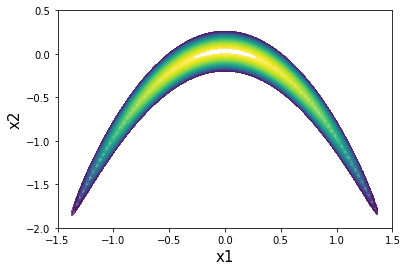

In [8]:
Bana_dist = Banana_dist(mu_1,cov_1)
Bana_dist.draw_post()

In [9]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

dtype = tf.float32
num_particles = 250
num_latent = 2
lr = 0.003
alpha = .9
fudge_factor = 1e-6
num_iter = 10000
range_limit = [-3, 3]
npoints_plot = 50

z_np = tf.convert_to_tensor(-np.random.randn(num_particles,
                                             num_latent)*2.0, dtype=tf.float32)


def svgd_kernel(X0):
    XY = tf.matmul(X0, tf.transpose(X0))
    X2_ = tf.reduce_sum(tf.square(X0), axis=1)

    x2 = tf.reshape(X2_, shape=(tf.shape(X0)[0], 1))

    X2e = tf.tile(x2, [1, tf.shape(X0)[0]])
    ## (x1 -x2)^2 + (y1 -y2)^2
    H = tf.subtract(tf.add(X2e, tf.transpose(X2e)), 2 * XY)

    V = tf.reshape(H, [-1, 1])

    # median distance
    def get_median(v):
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2
        return tf.nn.top_k(v, m).values[m-1]
    h = get_median(V)
    h = tf.sqrt(
        0.5 * h / tf.math.log(tf.cast(tf.shape(X0)[0], tf.float32) + 1.0))

    # compute the rbf kernel
    Kxy = tf.exp(-H / h ** 2 / 2.0)

    dxkxy = tf.negative(tf.matmul(Kxy, X0))
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=1), 1)
    dxkxy = tf.add(dxkxy, tf.multiply(X0, sumkxy)) / (h ** 2)

    return (Kxy, dxkxy)


def get_median(v):
    v = tf.reshape(v, [-1])
    m = v.get_shape()[0]//2
    return tf.nn.top_k(v, m).values[m-1]


@tf.function
def gradient(z_np, unnormalized_posterior_log_prob):
    with tf.GradientTape() as t:
        t.watch(z_np)
        f = unnormalized_posterior_log_prob(z_np)
    log_p_grad = tf.squeeze(t.gradient(f, z_np))
    return log_p_grad


def run_svgd(unnormalized_posterior_log_prob):
    global z_np
    for _ in range(num_iter):
        log_p_grad = gradient(z_np, unnormalized_posterior_log_prob)
        kernel_matrix, kernel_gradients = svgd_kernel(z_np)
        grad_theta = (tf.matmul(kernel_matrix, log_p_grad) +
                      kernel_gradients)/num_particles
        z_np = z_np+lr*grad_theta
    return z_np


In [10]:
class VI():
    def __init__(self, target_distribution=Banana_dist()):
        self.target_distribution = target_distribution

    @tf.function
    def unnormalized_posterior_log_prob(self, *args):
        return self.target_distribution.joint_log_post(*args)

    def run_inference(self):
        self.results = run_svgd(self.unnormalized_posterior_log_prob)
        return self.results

    def plot(self):
        range_limit = [-2, 2]
        _, ax = plt.subplots(figsize=(15, 7))
        ax = plt.subplot(1, 3, 1, aspect='equal')
        plt.scatter(self.results[:, 0], self.results[:, 1], s= 2.8, c = 'k')
        plt.xlim(range_limit)
        plt.ylim(range_limit)
        ax.set_title('Updated particles: $p_0(z)$')


In [11]:
vi = VI(Bana_dist)
result = vi.run_inference()

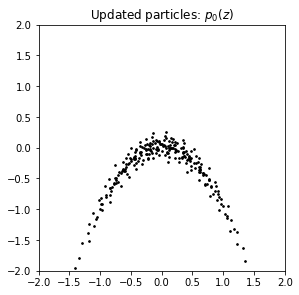

In [ ]:
vi.plot()

In [12]:
from IPython.display import HTML
from matplotlib import animation

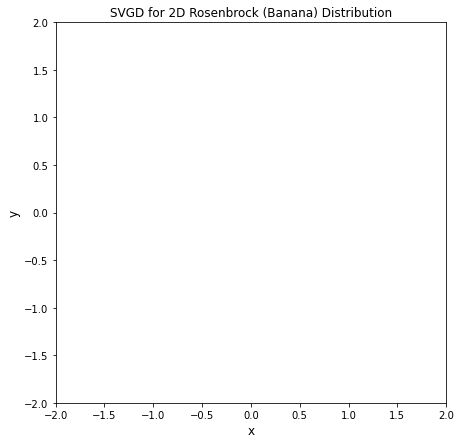

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlim(( -2, 2))
ax.set_ylim((-2, 2))

num_particles = 250
num_latent = 2
num_iter = 10000
range_limit = [-2, 2]
npoints_plot = 50

z_np = tf.convert_to_tensor(-np.random.randn(num_particles, num_latent)*2.0,dtype = tf.float32)
particels, = ax.plot(z_np[:,0], z_np[:,1], '.',c = 'k')
#ax.set_facecolor('darkslateblue')
#o = plt.contourf(*data, 25, levels=10, cmap="RdBu_r")

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('SVGD for 2D Rosenbrock (Banana) Distribution')

lr = 0.002

def init():
    particels.set_data([], [])
    return (particels,)


def animate(i):
    global z_np, lr
    log_p_grad = gradient(z_np,Bana_dist.joint_log_post)
    kernel_matrix, kernel_gradients = svgd_kernel(z_np)
    grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
    z_np = z_np+lr*grad_theta
    particels.set_data(z_np[:,0], z_np[:,1])

    return (particels,)


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=2500,interval=20, blit=False)
    
anim.save('Banana_SVGD.mp4')
